### Task 0 Before your go

> 1. Rename Assignment-02-###.ipynb where ### is your student ID.
> 2. The deadline of Assignment-02 is 23:59pm, 04-21-2024
> 3. In this assignment, you will use word embeddings to explore our Wikipedia dataset.

In [9]:
# import all libraries needed for the project
import json
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
import numpy as np
import random
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import pickle
from tqdm import tqdm

### Task 1 Train word embeddings using SGNS 
> Use our enwiki-train.json as training data. You can use the [Gensim tool](https://radimrehurek.com/gensim/models/word2vec.html). But it is recommended to implement by yourself. You should explain how hyper-parameters such as dimensionality of embeddings, window size, the parameter of negative sampling strategy, and initial learning rate have been chosen.

#### Load raw data

In [2]:
# Load data
import json

def load_data(file_path):
    with open(file_path, 'r') as file:
        data = [json.loads(line) for line in file.readlines()]
    return data

train_path = 'enwiki-train.json'
test_path = 'enwiki-test.json'

train_data = load_data(train_path)
test_data = load_data(test_path)

#### Prepocess data

In [ ]:
# Preprocess using gensim's simple_preprocess; save to file
from gensim.utils import simple_preprocess

def preprocess(data):
    '''Return a list of tokenized sentences, where each element is a word list from one text.'''
    sentences = []
    for item in data:
        sentences.append(simple_preprocess(item['text']))
    return sentences

def save_sents(data, file_path):
    with open(file_path, 'w', encoding='utf-8') as file:
        for sentence in data:
            file.write(' '.join(sentence) + '\n')

train_prep = 'enwiki-train-processed.txt'
test_prep = 'enwiki-test-processed.txt'

train_sents = preprocess(train_data)
test_sents = preprocess(test_data)

save_sents(train_sents, train_prep)
save_sents(test_sents, test_prep)

In [3]:
# load preprocessed data
def load_sents(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(line.strip().split())
    return data

train_prep = 'enwiki-train-processed.txt'
test_prep = 'enwiki-test-processed.txt'

train_sents = load_sents(train_prep)
test_sents = load_sents(test_prep)

#### Use `gensim` to train word embeddings

In [7]:
# Use gensim model Word2Vec
from gensim.models import Word2Vec

# Train the model
# alpha: The initial learning rate.
# min_count: Ignores all words with total frequency lower than this.
# sample: The threshold for configuring which higher-frequency words are randomly downsampled.
# sorted_vocab: If 1, sort the vocabulary by descending frequency before assigning word indexes.
model_gensim = Word2Vec(sentences=train_sents, vector_size=100, alpha=0.025, window=5,
                            min_count=5, sample=0.001, seed=43, workers=10, min_alpha=0.0001,
                            sg=1, negative=10, ns_exponent=0.75, epochs=5, sorted_vocab=1)

# Save the model
model_gensim.save('gensim_sgns.model')

#### Implement the SGNS algorithm by hand

In the following code, we learn both target embedding matrix W and context embedding matrix C, and we simply drop C to get the final word embedding matrix W.

The hyperparameters for our model are set based on a combination of empirical evidence from previous research, practical considerations of computational resources, and performance trade-offs observed in our preliminary experiments. Here are the details:

1. **Dimensionality of Embeddings: 100**

To save training time and retain good performance, we choose a relatively lower size according to experiments in [GloVe](https://nlp.stanford.edu/pubs/glove.pdf) (Pennington et al., 2014), which claimed that embeddings of this size are typically sufficient to capture semantic relationships in text.

2. **Window Size: 5**

This size is common in the literature, as mentioned in the original [word2vec paper](https://arxiv.org/abs/1301.3781) (Mikolov et al., 2013). A small window size allows the model to capture syntactic relationships, while a larger one can help in capturing broader topical content. We choose a window size of 5 words on either side of the target word, which is also time-efficient.

3. **Negative Sampling: 5**

In the [follow-up work](https://arxiv.org/abs/1310.4546) (Mikolov et al., 2013), the authors introduced negative sampling and empirically showed that k = 5 ~ 20 is a good choice for small data sets. We use 5 negative samples for each positive example to balance training efficiency and learning effectiveness.

4. **Learning Rate (Initial: 0.025, Minimum: 0.0001)**

The learning rate starts at 0.025 and linearly decreases to 0.0001 as training progresses. This is also discussed in the follow-up paper above, and it helps in stabilizing the training process and making convergence better.

5. **ns_exponent: 0.75**

This parameter is used in the negative sampling strategy to control the distribution of negative samples. An exponent of 0.75 yielded the best results in the original paper, so we use the same value here.

6. **Epochs: 1**

At first we want to train the model for 5 epochs, as done in the calling of GenSim. But due to time cost, we just train the model for 1 epoch.

In [4]:
# Implement Word2Vec from scratch
from nltk import FreqDist
from tqdm import tqdm
import random
import numpy as np
import pickle


class myWord2Vec:
    def __init__(self, sentences=None, vector_size=100, window=5,
                 min_count=5, negative=5, alpha=0.025, min_alpha=0.0001, 
                 ns_exponent=0.75, epochs=1, seed=43):
        '''Train a Word2Vec model using Skip-gram with Negative Sampling (SGNS).
        
        Args:
        - sentences: list of lists of strings, tokenized sentences.
        - vector_size: int, dimension of the word embedding vectors.
        - window: int, maximum distance between the current and predicted word within a sentence.
        - min_count: int, ignores all words with total frequency lower than this.
        - negative: int, specifies how many "noise words" should be drawn for negative sampling.
        - alpha: float, the initial learning rate.
        - min_alpha: float, learning rate will linearly drop to min_alpha as training progresses.
        - ns_exponent: float, the exponent used to shape the negative sampling distribution.
        - epochs: int, number of iterations (epochs) over the corpus.
        - seed: int, random seed for reproducibility.
        '''
        self.vector_size = vector_size
        self.window = window
        self.min_count = min_count
        self.negative = negative
        self.alpha = alpha
        self.min_alpha = min_alpha
        self.ns_exponent = ns_exponent
        self.vocab = None  # dictionary, word: count
        self.index2word = None  # index to word mapping
        self.word_index = None  # word to index mapping
        self.W = None  # embedding matrix for target words
        self.C = None  # embedding matrix for context words
        
        if sentences is not None:
            np.random.seed(seed)
            self.build_vocab(sentences)
            self._init_unigram_table()
            self.train(sentences, epochs)
        
    def build_vocab(self, corpus):
        '''Build the vocabulary and initialize parameters.'''
        fdist = FreqDist(word for sentence in corpus for word in sentence)
        self.vocab = {word: count for word,
                      count in fdist.items() if count >= self.min_count}
        self.word_index = {word: idx for idx, word in enumerate(self.vocab)}
        self.index2word = {idx: word for word, idx in self.word_index.items()}
        self._init_params()

    def _init_params(self):
        '''Initialize the embedding matrices W and C.'''
        vocab_size = len(self.vocab)
        self.W = np.random.uniform(-0.5, 0.5, (vocab_size, self.vector_size)) / self.vector_size
        self.C = np.zeros((vocab_size, self.vector_size))
    
    def _init_unigram_table(self):
        '''Initialize a unigram table using weighted frequency.
        To sample negative examples efficiently, we build a table of indices
        where each word is repeated a number of times proportional to its frequency
        raised to the power of 0.75.
        '''
        vocab_counts = [self.vocab[word] **
                        self.ns_exponent for word in self.vocab]
        total_count = sum(vocab_counts)
        self.unigram_table = []
        for word, count in self.vocab.items():
            word_idx = self.word_index[word]
            adjusted_count = int((count ** self.ns_exponent / total_count) * 1e5)
            self.unigram_table.extend([word_idx] * adjusted_count)

    def train(self, corpus, epochs):
        '''Train the Word2Vec model using SGNS.'''
        for epoch in range(epochs):
            progress_bar = tqdm(total=len(corpus), desc=f'Epoch {epoch + 1}')
            for sentence in corpus:
                for target_pos, target_word in enumerate(sentence):
                    if target_word not in self.word_index:
                        continue
                    target_idx = self.word_index[target_word]  # index of the target word in the vocabulary/W matrix
                    context_positions = range(max(0, target_pos - self.window), min(len(sentence), target_pos + self.window + 1))
                    for context_pos in context_positions:
                        if context_pos != target_pos and sentence[context_pos] in self.word_index:
                            context_idx = self.word_index[sentence[context_pos]]
                            self.update(target_idx, context_idx)  # update the W and C matrices
                progress_bar.update(1)
            progress_bar.close()

    def update(self, target_idx, context_idx):
        '''Update W and C matrices based on the current pair of target and context words.'''
        # negative sampling
        negatives = []
        while len(negatives) < self.negative:
            sampled_idx = random.choice(self.unigram_table)
            if sampled_idx != target_idx:  # exclude the target word
                negatives.append(sampled_idx)
        indices = [context_idx] + negatives
        labels = [1] + [0] * self.negative

        tmp_cum = np.zeros_like(self.W[target_idx])

        for idx, label in zip(indices, labels):
            # dot product of the target and context word vectors
            z = np.dot(self.W[target_idx], self.C[idx])
            p = self.sigmoid(z)  # predicted probability
            g = self.alpha * (label - p)
            tmp_cum += g * self.C[idx]
            self.C[idx] += g * self.W[target_idx]

        self.W[target_idx] += tmp_cum
        
        # Alternatively, use vectorized operations to accelerate the computation
        # z = np.dot(self.C[indices], self.W[target_idx])
        # p = self.sigmoid(z)
        # g = self.alpha * (labels - p)
        # self.C[indices] += np.outer(g, self.W[target_idx])
        # self.W[target_idx] += np.dot(g, self.C[indices])


    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    def save_embeddings(self, file_name):
        with open(file_name, 'w') as f:
            for word, idx in self.word_index.items():
                vector = ' '.join(map(str, self.W[idx]))
                f.write(f'{word} {vector}\n')

    def save_model(self, file_name):
        with open(file_name, 'wb') as f:
            pickle.dump(self, f) 

# Train the model
model_hand = myWord2Vec(sentences=train_sents)
model_hand.save_embeddings("hand_sgns.txt")
model_hand.save_model('hand_sgns.pkl')

Epoch 1: 100%|██████████| 1000/1000 [1:04:14<00:00,  3.85s/it]


#### Load embedding models

In [4]:
# Load gensim model
model_gensim = Word2Vec.load('gensim_sgns.model')

In [5]:
# Load hand-crafted embeddings
def load_embeddings(file_name):
    embeddings = {}
    with open(file_name, 'r') as f:
        for line in f:
            parts = line.strip().split()
            word = parts[0]
            vector = np.array([float(x) for x in parts[1:]])
            embeddings[word] = vector
    return embeddings

embedding_hand = load_embeddings("hand_sgns.txt")

In [8]:
# Load hand-crafted model
import pickle

def load_model(file_name):
    with open(file_name, 'rb') as f:
        return pickle.load(f)

model_hand = load_model('hand_sgns.pkl')

### Task 2 Find similar/dissimilar word pairs

> Randomly generate 100, 1000, and 10000-word pairs from the vocabularies. For each set, print 5 closest word pairs and 5 furthest word pairs (you can use cosine-similarity to measure two words). Explain your results.

In [18]:
import random
from gensim.models import Word2Vec


def generate_word_pairs(words, n_pairs):
    """Generate n random word pairs from the model's vocabulary."""
    word_pairs = []
    while len(word_pairs) < n_pairs:
        w1, w2 = random.sample(words, 2)
        if w1 != w2:
            word_pairs.append((w1, w2))
    return word_pairs


def cosine_similarity(vec1, vec2):
    vec1 = vec1 / np.linalg.norm(vec1) if np.linalg.norm(vec1) > 1e-10 else 0
    vec2 = vec2 / np.linalg.norm(vec2) if np.linalg.norm(vec2) > 1e-10 else 0
    return np.dot(vec1, vec2)


def evaluate_similarity(model, model_type, word_pairs):
    """Evaluate word pairs and return sorted lists of closest and furthest pairs."""
    if model_type == 1:
        pairs_with_similarity = [
            (w1, w2, model.wv.similarity(w1, w2)) for w1, w2 in word_pairs]
    elif model_type == 2:
        pairs_with_similarity = [
            (w1, w2, cosine_similarity(model[w1], model[w2])) for w1, w2 in word_pairs]
    
    # Sort by similarity
    sorted_pairs = sorted(pairs_with_similarity, key=lambda x: x[2], reverse=True)
    closest_pairs = sorted_pairs[:5]
    furthest_pairs = sorted_pairs[-5:]
    
    return closest_pairs, furthest_pairs


def present_results(vocab, n_pairs):
    # Generate word pairs
    pairs = generate_word_pairs(vocab, n_pairs)
    print("=====Gensim model:=====")
    # Evaluate word pairs
    closest, furthest = evaluate_similarity(model_gensim, 1, pairs)
    print(f"Closest pairs:")
    for w1, w2, sim in closest:
        print(f"{w1} - {w2}: {sim:.4f}")
    print(f"\nFurthest pairs:")
    for w1, w2, sim in furthest:
        print(f"{w1} - {w2}: {sim:.4f}")
    print("\n=====Hand-crafted model:=====")
    closest, furthest = evaluate_similarity(embedding_hand, 2, pairs)
    print(f"Closest pairs:")
    for w1, w2, sim in closest:
        print(f"{w1} - {w2}: {sim:.4f}")
    print(f"\nFurthest pairs:")
    for w1, w2, sim in furthest:
        print(f"{w1} - {w2}: {sim:.4f}")


# Get the vocabulary
vocab = list(model_gensim.wv.key_to_index.keys())  # list of words in the vocabulary

print("======100-word pairs:======")
present_results(vocab, 100)
print("\n======1000-word pairs:======")
present_results(vocab, 1000)
print("\n======10000-word pairs:======")
present_results(vocab, 10000)

======100-word pairs:======
=====Gensim model:=====
Closest pairs:
phyllo - guardsman: 0.8537
ingram - schell: 0.8479
symbiosis - hone: 0.8272
emit - kras: 0.8257
branson - trough: 0.8217

Furthest pairs:
harare - talents: 0.2781
neuilly - creation: 0.2572
slavery - lodged: 0.2572
agnes - popularly: 0.2511
autoimmune - molded: 0.2130

=====Hand-crafted model:=====
Closest pairs:
anker - indict: 0.9399
phyllo - guardsman: 0.9263
ingram - schell: 0.9218
conceivable - extraneous: 0.9201
branson - trough: 0.9146

Furthest pairs:
doubleday - egyptian: 0.4357
neuilly - creation: 0.3909
specimens - oak: 0.3737
slavery - lodged: 0.3568
last - hearst: 0.2814

======1000-word pairs:======
=====Gensim model:=====
Closest pairs:
coincidental - rona: 0.9036
nigrescens - claustrophobia: 0.8894
overstuffed - depress: 0.8745
collodion - moisturizers: 0.8617
upsetting - maltreatment: 0.8568

Furthest pairs:
big - distress: 0.1075
colonialism - murdoch: 0.0994
ann - syria: 0.0680
academically - cero: 0.

- For $n=100$, we see that both models present similar closest and furthest word pairs, except for some rank changes. The simlarity values are not very high for the closest and not very low for the furthest pairs.
- As $n$ increases, the range of similarity values becomes wider, as negative values appear in the furthest pairs. This is due to the increased number of random pairs, which may include unrelated words. The pairs do not remain consistent across models, probably due to different training processes and random initializations.
- We observe that the most similar pairs are not semantically related as we usually expect, and there are rare words listed, especially in the closest pairs. This is because the model captures the co-occurrence patterns in the training data, which may not always reflect semantic relationships. When some rare words appear less frequently in the whole text, but they co-occur with each other, they can be considered similar by the model. Conversely, some common words may appear in various contexts and have low similarity scores with other words.

### Task 3 Present a document as an embedding

> For each document, you have several choices to generate document embedding: 1. Use the average of embeddings of all words in each document; 2. Use the first paragraph’s words and take an average on these embeddings; 3. Use the doc2vec algorithm to present each document. Do the above for both training and testing dataset

For the following tasks, we utilize our hand-crafted embeddings, whereas the Gensim embeddings can also be used in the same way.

Choice 1: Use the average of embeddings of all words in each document

In [25]:
def avg_embedding(doc, model, model_type):
    # a doc is a list of words
    if model_type == 1:  # gensim model
        words = [model.wv[word]
                 for word in doc if word in vocab]  # remove out-of-vocabulary words
        return np.mean(words, axis=0) if doc else np.zeros(model.vector_size)
    elif model_type == 2:  # hand-crafted model
        words = [model[word] for word in doc if word in vocab]
        return np.mean(words, axis=0)


model_gensim = Word2Vec.load('gensim_sgns.model')
vocab = list(model_gensim.wv.key_to_index.keys())

traindoc_avg = []
testdoc_avg = []

for i, item in tqdm(enumerate(train_data), total=len(train_data)):
    traindoc_avg.append({'label': item['label'], 'embedding': avg_embedding(
        train_sents[i], embedding_hand, 2)})
for i, item in tqdm(enumerate(test_data), total=len(test_data)):
    testdoc_avg.append({'label': item['label'], 'embedding': avg_embedding(
        test_sents[i], embedding_hand, 2)})
    
# for i, item in tqdm(enumerate(train_data), total=len(train_data)):
#     traindoc_avg.append({'label': item['label'], 'embedding': avg_embedding(
#         train_sents[i], model_gensim, 1)})
# for i, item in tqdm(enumerate(test_data), total=len(test_data)):
#     testdoc_avg.append({'label': item['label'], 'embedding': avg_embedding(
#         test_sents[i], model_gensim, 1)})

100%|██████████| 100/100 [00:29<00:00,  3.42it/s]


Choice 2: Use the first paragraph’s words and take an average on these embeddings

In [26]:
from gensim.utils import simple_preprocess

traindoc_first = []
testdoc_first = []

for i, item in tqdm(enumerate(train_data), total=len(train_data)):
    paragraphs = train_data[i]['text'].split('\n')
    j = 0
    result = []
    while len(result) < 1:  # in case the first paragraph is empty
        result = [word for word in simple_preprocess(paragraphs[j]) if word in vocab]
        j += 1
    traindoc_first.append({'label': item['label'], 'embedding': avg_embedding(result, embedding_hand, 2)})

for i, item in tqdm(enumerate(test_data), total=len(test_data)):
    paragraphs = test_data[i]['text'].split('\n')
    j = 0
    result = []
    while len(result) < 1:
        result = [word for word in simple_preprocess(paragraphs[j]) if word in vocab]
        j += 1
    testdoc_first.append({'label': item['label'], 'embedding': avg_embedding(result, embedding_hand, 2)})

100%|██████████| 100/100 [00:00<00:00, 159.04it/s]


Choice 3: Use the doc2vec algorithm to present each document

In [12]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

traindoc_doc2vec = []
testdoc_doc2vec = []

# Create TaggedDocument objects
tagged_docs = [TaggedDocument(doc, [i]) for i, doc in enumerate(train_sents)]

# Train the model
doc2vec_model = Doc2Vec(vector_size=100, window=5,
                        min_count=5, workers=4, epochs=40)
doc2vec_model.build_vocab(tagged_docs)
doc2vec_model.train(tagged_docs, total_examples=doc2vec_model.corpus_count,
                    epochs=doc2vec_model.epochs)


for i, item in tqdm(enumerate(train_data), total=len(train_data)):
    traindoc_doc2vec.append({'label': item['label'], 'embedding': doc2vec_model.dv[i]})
for i, item in tqdm(enumerate(test_data), total=len(test_data)):
    testdoc_doc2vec.append({'label': item['label'], 'embedding': doc2vec_model.infer_vector(test_sents[i])})

100%|██████████| 100/100 [00:23<00:00,  4.29it/s]


### Task 4 Build classifier to test docs
> Build softmax regression model to classifier testing documents based on these training doc embeddings. Does it getting better than Naive Bayes'? (You have 3 models.)

In [27]:
from sklearn.linear_model import LogisticRegression

def train_classifier(traindoc):
    '''Train a logistic regression classifier.'''
    X_train = np.array([doc['embedding'] for doc in traindoc])
    y_train = np.array([doc['label'] for doc in traindoc])
    
    model = LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=1000)

    model.fit(X_train, y_train)

    return model, model.score(X_train, y_train)


def evaluate_classifier(traindoc, testdoc):
    '''Evaluate the classifier on the test set.'''
    model, train_acc = train_classifier(traindoc)
    X_test = np.array([doc['embedding'] for doc in testdoc])
    y_test = np.array([doc['label'] for doc in testdoc])

    return train_acc, model.score(X_test, y_test)

In [28]:
# Model 1
print("Model 1: Average of all word embeddings in a document")
train_acc, test_acc = evaluate_classifier(traindoc_avg, testdoc_avg)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

# Model 2
print("Model 2: Average of the first paragraph's word embeddings in a document")
train_acc, test_acc = evaluate_classifier(traindoc_first, testdoc_first)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

# Model 3
print("Model 3: Doc2Vec embeddings")
train_acc, test_acc = evaluate_classifier(traindoc_doc2vec, testdoc_doc2vec)
print(f"Train accuracy: {train_acc:.2f}")
print(f"Test accuracy: {test_acc:.2f}")

Model 1: Average of all word embeddings in a document
Train accuracy: 0.94
Test accuracy: 0.92
Model 2: Average of the first paragraph's word embeddings in a document
Train accuracy: 0.92
Test accuracy: 0.88
Model 3: Doc2Vec embeddings
Train accuracy: 1.00
Test accuracy: 0.94


In Assignment 01, we used Naive Bayes' to achieve an accuracy of 0.81 in the test set based on the bag-of-words representation. Now, we use the document embeddings to build a softmax regression model, and all three models outperform Naive Bayes'.

From the accuracy results, we can see that the model using doc2vec embeddings performs best, as it may learn more meaningful and inherent representations of the documents rather than just averaging the word embeddings.

The model using the average of all words in each document performs the second best, while the model using the first paragraph's words performs the worst. 

This is likely because the first two methods capture more information about the document content, while the last model only considers the first paragraph, which may not be representative of the whole document.

### Task 5 Use t-SNE to project doc vectors

> Use t-SNE to project training document embeddings into 2d and plot them out for each of the above choices. Each point should have a specific color (represent a particular cluster). You may need to try different parameters of t-SNE. One can find more details about t-SNE in this [excellent article](https://distill.pub/2016/misread-tsne/).

In [35]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

def tsne_plot(traindoc):
    X = np.array([doc['embedding'] for doc in traindoc])
    y = np.array([doc['label'] for doc in traindoc])
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=43, n_iter=300, perplexity=10, learning_rate="auto")
    X_2d = tsne.fit_transform(X)
    
    plt.figure(figsize=(7, 4))
    scatter = plt.scatter(X_2d[:, 0], X_2d[:, 1], c=y_encoded, cmap='tab10', alpha=1)
    colorbar = plt.colorbar(scatter)
    colorbar.set_ticks(np.arange(len(label_encoder.classes_)))
    colorbar.set_ticklabels(label_encoder.classes_)
    plt.title('t-SNE projection of document embeddings')
    plt.show()

Model 1: Average of all word embeddings in a document


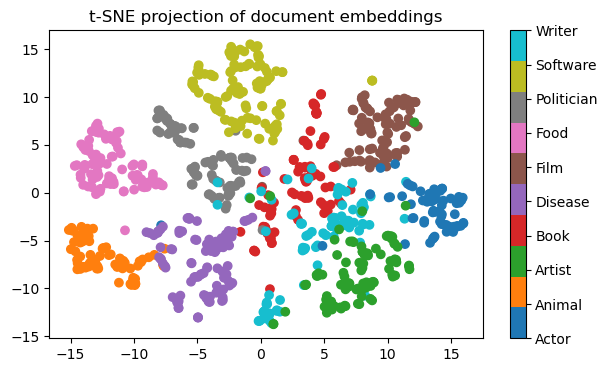

In [36]:
# Model 1
print("Model 1: Average of all word embeddings in a document")
tsne_plot(traindoc_avg)

Model 2: Average of the first paragraph's word embeddings in a document


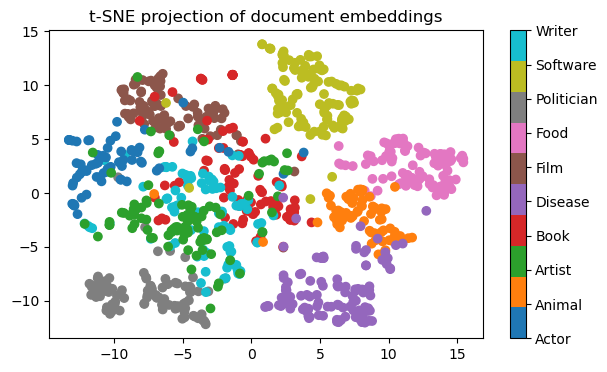

In [37]:
# Model 2
print("Model 2: Average of the first paragraph's word embeddings in a document")
tsne_plot(traindoc_first)

Model 3: Doc2Vec embeddings


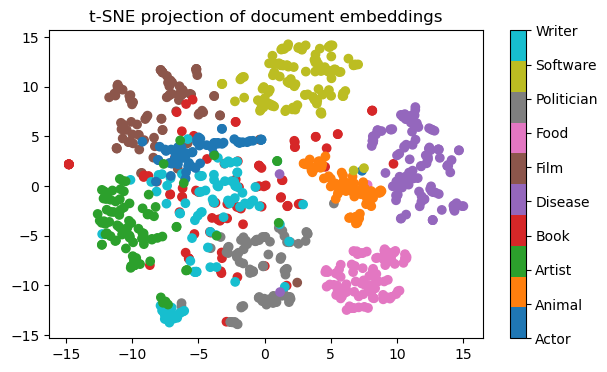

In [38]:
# Model 3
print("Model 3: Doc2Vec embeddings")
tsne_plot(traindoc_doc2vec)

We observe that the t-SNE plots show distinct clusters for different documents, which indicates that the document embeddings capture the underlying structure of the data. The clusters are more separated in model 1 and model 3, while model 2 shows more overlap between clusters. This is consistent with the accuracy results, where model 1 and model 3 perform better than model 2.

We also observe that different models lead to different locations of the clusters, but they all show separability between classes.